<a href="https://colab.research.google.com/github/jmcord/stylegan3-training-notebook/blob/main/styleGan3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### 01. Connect to your Google Drive

Run the code below to connect to your Google Drive folders.
You will be prompted for permissions to access your drive.


In [1]:
try:
    from google.colab import drive

    drive.mount("/content/drive", force_remount=True)
    COLAB = True
    print("Note: using Google CoLab")
except:
    print("Note: not using Google CoLab")
    COLAB = False


Mounted at /content/drive
Note: using Google CoLab


### 02. Verify if GPUs are turned on and available

If the `nvidia-smi` script does not return any GPUs, you need to turn on GPUs in:

```
Menu -> Runtime -> Change runtime type -> Hardware Accelerator Dropdown -> select "GPU"
```

In [ ]:
# Verify if GPUs are available
!nvidia-smi

Tue Jul 25 15:38:54 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   64C    P8    11W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
# Install dependencies and clone StyleGAN3

!pip install torch==2.0.1 torchvision
!git clone https://github.com/NVlabs/stylegan3.git
!pip install ninja

Cloning into 'stylegan3'...
remote: Enumerating objects: 212, done.
remote: Counting objects: 100% (5/5), done.
remote: Compressing objects: 100% (5/5), done.
remote: Total 212 (delta 0), reused 1 (delta 0), pack-reused 207
Receiving objects: 100% (212/212), 4.17 MiB | 19.70 MiB/s, done.
Resolving deltas: 100% (98/98), done.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 146.0/146.0 kB 3.3 MB/s eta 0:00:00


### 03. Create folders for training

Create a folder structure in your Google Drive:

```
├── stylegan
│   ├── images
│   │   ├── <Your dataset folder containing images with dimensions of power of 2 (ex. - 64x64, 128x128, 1024x1024)>
│   ├── datasets
│   ├── experiments
```

You can use [ImageMagick's](https://imagemagick.org/) batch image processor script `mogrify` locally before uploading to Google Drive to make sure all your images

Take note of your raw dataset folder name and put it in the `RAW_DATASET_FOLDER_NAME` variable below.


In [3]:
import os

# Change this to your dataset folder name
RAW_DATASET_FOLDER_NAME = "trainA"

STYLEGAN_ROOT_FOLDER = os.path.join(
    os.sep, "content", "drive", "MyDrive", "stylegan"
)
RAW_DATASET_PATH = os.path.join(STYLEGAN_ROOT_FOLDER, "images", RAW_DATASET_FOLDER_NAME)
ZIP_DATASET_PATH = os.path.join(STYLEGAN_ROOT_FOLDER, "datasets", RAW_DATASET_FOLDER_NAME + ".zip")
EXPERIMENTS_PATH = os.path.join(STYLEGAN_ROOT_FOLDER, "experiments")


In [ ]:
dataset_creation_cmd = f"python /content/stylegan3/dataset_tool.py --source={RAW_DATASET_PATH} --dest={ZIP_DATASET_PATH}"
!{dataset_creation_cmd}

 36% 202/562 [00:03<00:04, 74.62it/s]Error: Image 00000/img00000203.png attributes must be equal across all images of the dataset.  Got:
  dataset width/cur image width: 256/256
  dataset height/cur image height: 256/256
  dataset channels/cur image channels: 3/1
 36% 203/562 [00:03<00:05, 66.63it/s]


In [ ]:
# Verifies your dataset for inconsistent sizes and colour formats
# Script created by @jeffheaton

from os import listdir
from os.path import isfile, join
import os
from PIL import Image
from tqdm.notebook import tqdm


files = [f for f in listdir(RAW_DATASET_PATH) if isfile(join(RAW_DATASET_PATH, f))]

base_size = None
for file in tqdm(files):
    file2 = os.path.join(RAW_DATASET_PATH, file)
    img = Image.open(file2)
    sz = img.size
    if base_size and sz != base_size:
        print(f"Inconsistant size: {file2}")
    elif img.mode != "RGB":
        print(f"Inconsistant color format: {file2}")
    else:
        base_size = sz


  0%|          | 0/562 [00:00<?, ?it/s]

Inconsistant color format: /content/drive/MyDrive/stylegan/images/trainA/00504.jpg
Inconsistant color format: /content/drive/MyDrive/stylegan/images/trainA/00644.jpg


### 04. Training

You can play around with different configurations here. A few descriptions:

- `CFG` - you can pick `stylegan3-t` (only designed for translation equivariance) or `stylegan3-r` (features high-quality, though not visually perfect rotation equivariance). More details in the [official NVIDIA StyleGAN3 documentation](https://nvlabs.github.io/stylegan3/)
- `BATCH_SIZE` - the number of samples that will be passed through to the network at one time
- `BATCH_GPU` - per-GPU batch size
- `GAMMA` - R1 regularization weight
- `SNAP` - number of epochs before saving a new checkpoint in the `experiments` folder on Google Drive (for Google Colab Free, it is recommended to keep this low, say `5` or `10`)

You can refer to the [official documentation's recommended configurations](https://github.com/NVlabs/stylegan3/blob/main/docs/configs.md#recommended-configurations) to see more config parameters.

In [ ]:
import os

# Modify these to suit your needs
CFG = "stylegan3-t"
BATCH_SIZE = 10
BATCH_GPU = 16
GAMMA = 0.5
SNAP = 5

# Build the command and run it
cmd = f"/usr/bin/python3 /content/stylegan3/train.py --outdir={EXPERIMENTS_PATH} --data={ZIP_DATASET_PATH} --cfg={CFG} --gpus=1 --workers=1 --batch={BATCH_SIZE} --batch-gpu={BATCH_GPU} --gamma={GAMMA} --snap={SNAP}"
!{cmd}

NameError: ignored

### 05. Resuming training

Your Colab instance will automatically be turned off after 12 hours (Colab Free) or 24 hours (Colab Pro/Pro+).
You can resume training with the code below.

Check your Google Drive folder to check the `CHECKPOINT_FOLDER` and `NETWORK` name in the `experiments` folder.
An example of this is:

```
├── stylegan
│   ├── images
│   ├── dataset
│   ├── experiments
│   │   ├── 00002-dogs_images-auto1-resumecustom --> This is the `CHECKPOINT_FOLDER`
│   │   │   ├── network-snapshot-000160.pkl --> This is the `NETWORK`
```

You can use the `NETWORK` with the latest epoch to continue.
The confgurations are the same as the ones in *04. Training*.

In [ ]:
# Resume Training

import os

# Modify these to suit your needs
CHECKPOINT_FOLDER = "00016-stylegan3-t-trainA-gpus1-batch32-gamma0.5"
NETWORK = "network-snapshot-000000.pkl"
RESUME = os.path.join(EXPERIMENTS_PATH, CHECKPOINT_FOLDER, NETWORK)

# Modify these to suit your needs
CFG = "stylegan3-t"
BATCH_SIZE = 32
BATCH_GPU = 16
GAMMA = 0.5
SNAP = 5

# Build the command and run it
cmd = f"/usr/bin/python3 /content/stylegan3/train.py --resume={RESUME} --outdir={EXPERIMENTS_PATH} --data={ZIP_DATASET_PATH} --cfg={CFG} --gpus=1 --workers=1 --batch={BATCH_SIZE} --batch-gpu={BATCH_GPU} --gamma={GAMMA} --snap={SNAP}"
!{cmd}


Training options:
{
  "G_kwargs": {
    "class_name": "training.networks_stylegan3.Generator",
    "z_dim": 512,
    "w_dim": 512,
    "mapping_kwargs": {
      "num_layers": 2
    },
    "channel_base": 32768,
    "channel_max": 512,
    "magnitude_ema_beta": 0.9988915792636801
  },
  "D_kwargs": {
    "class_name": "training.networks_stylegan2.Discriminator",
    "block_kwargs": {
      "freeze_layers": 0
    },
    "mapping_kwargs": {},
    "epilogue_kwargs": {
      "mbstd_group_size": 4
    },
    "channel_base": 32768,
    "channel_max": 512
  },
  "G_opt_kwargs": {
    "class_name": "torch.optim.Adam",
    "betas": [
      0,
      0.99
    ],
    "eps": 1e-08,
    "lr": 0.0025
  },
  "D_opt_kwargs": {
    "class_name": "torch.optim.Adam",
    "betas": [
      0,
      0.99
    ],
    "eps": 1e-08,
    "lr": 0.002
  },
  "loss_kwargs": {
    "class_name": "training.loss.StyleGAN2Loss",
    "r1_gamma": 0.5,
    "blur_init_sigma": 0
  },
  "data_loader_kwargs": {
    "pin_memory"

#Generate images

In [4]:
import matplotlib.pyplot as plt
from PIL import Image

In [5]:
seed = 1
!python /content/stylegan3/gen_images.py --network='/content/drive/MyDrive/stylegan/experiments/00016-stylegan3-t-trainA-gpus1-batch32-gamma0.5/network-snapshot-000000.pkl' --trunc=1 --seeds=$seed --outdir=/content/drive/MyDrive/stylegan/experiments/00015-stylegan3-t-trainA-gpus1-batch32-gamma0.5

Loading networks from "/content/drive/MyDrive/stylegan/experiments/00015-stylegan3-t-trainA-gpus1-batch32-gamma0.5/network-snapshot-000000.pkl"...
Generating image for seed 1 (0/1) ...
Setting up PyTorch plugin "bias_act_plugin"... Done.
Setting up PyTorch plugin "filtered_lrelu_plugin"... Done.


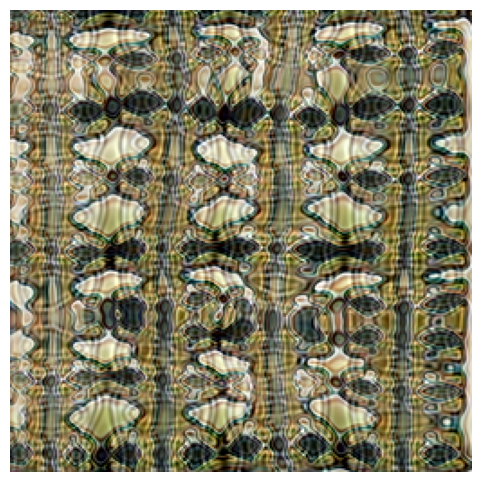

In [6]:
image = Image.open('/content/drive/MyDrive/stylegan/experiments/00015-stylegan3-t-trainA-gpus1-batch32-gamma0.5/seed%04d.png' % seed)
plt.figure(figsize = (6,6))
plt.axis('off')
plt.imshow(image)